# Azure AI Document Intelligence Demo

This notebook demonstrates the capabilities of Azure AI Document Intelligence (formerly Form Recognizer) including:
- **Prebuilt Models**: Extract data from invoices, receipts, business cards, and ID documents
- **Layout Analysis**: Analyze document structure, tables, and text regions
- **Custom Models**: Train models for specific document types
- **Document Classification**: Classify documents into different categories
- **Key-Value Pair Extraction**: Extract structured data from forms
- **Table Extraction**: Extract tables and their contents

## Prerequisites
- Azure subscription
- Azure Document Intelligence resource created in Azure portal
- Python 3.8 or higher
- Sample documents for testing (PDFs, images)

## 1. Setup and Package Installation

First, let's install the required Azure Document Intelligence SDK and supporting packages.

In [41]:
# Install required Azure Document Intelligence SDK and supporting packages
!pip install azure-ai-formrecognizer azure-identity python-dotenv
!pip install pillow matplotlib requests numpy pandas
# Install tabulate for nice table formatting
!pip install tabulate
# Install IPython for document processing and visualization
!pip install IPython

print("✅ All packages installed successfully!")
print("📦 Installed packages: azure-ai-formrecognizer, azure-identity, python-dotenv")
print("📦 Supporting packages: pillow, matplotlib, requests, numpy, pandas, tabulate, IPython")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All packages installed successfully!
📦 Installed packages: azure-ai-formrecognizer, azure-identity, python-dotenv
📦 Supporting packages: pillow, matplotlib, requests, numpy, pandas, tabulate, IPython



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
# Import required libraries
import os
import io
import json
import requests
from dotenv import load_dotenv
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from tabulate import tabulate
from IPython.display import display, Image as IPImage

# Azure Document Intelligence imports
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential

# Load environment variables
load_dotenv()

print("✅ Libraries imported successfully!")
print("📄 Ready to analyze documents with Azure AI Document Intelligence!")

✅ Libraries imported successfully!
📄 Ready to analyze documents with Azure AI Document Intelligence!


## 2. Azure Document Intelligence Configuration

### Option 1: Using Environment Variables (Recommended)
Set these environment variables in your system or create a `.env` file:
```
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT=https://your-resource.cognitiveservices.azure.com/
AZURE_DOCUMENT_INTELLIGENCE_KEY=your-api-key
```

### Option 2: Using Managed Identity (For Azure-hosted applications)
When running on Azure services with managed identity enabled.

In [43]:
import os
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential

# Configuration for Azure Document Intelligence Service
document_endpoint = os.getenv('AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT') or "https://your-resource.cognitiveservices.azure.com/"
document_key = os.getenv('AZURE_DOCUMENT_INTELLIGENCE_KEY') or "your-document-key-here"

print("🔧 AZURE DOCUMENT INTELLIGENCE CONFIGURATION")
print("=" * 50)

# Check if environment variables are properly set
if document_endpoint == "https://your-resource.cognitiveservices.azure.com/":
    print("⚠️  ENDPOINT NOT CONFIGURED")
    print("   Please set AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT environment variable")
    print("   Example: https://your-actual-resource.cognitiveservices.azure.com/")
else:
    print(f"✅ Endpoint configured: {document_endpoint}")

if document_key == "your-document-key-here":
    print("⚠️  API KEY NOT CONFIGURED")
    print("   Please set AZURE_DOCUMENT_INTELLIGENCE_KEY environment variable")
    print("   You can get this from your Azure Document Intelligence resource in the Azure portal")
else:
    print("✅ API Key configured: " + "*" * (len(document_key) - 4) + document_key[-4:])

# Create Document Intelligence client
if document_key and document_key != "your-document-key-here":
    try:
        credential = AzureKeyCredential(document_key)
        document_client = DocumentAnalysisClient(endpoint=document_endpoint, credential=credential)
        print(f"\n✅ Document Intelligence client created successfully!")
        print("🚀 Ready to analyze documents!")
    except Exception as e:
        print(f"\n❌ Error creating Document Intelligence client: {e}")
        print("   Please check your endpoint and API key")
        document_client = None
else:
    print(f"\n❌ Cannot create client - missing configuration")
    print("   To set up your credentials:")
    print("   1. Go to Azure Portal")
    print("   2. Create a Document Intelligence resource")
    print("   3. Copy the endpoint and key")
    print("   4. Set environment variables:")
    print("      AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT=https://your-resource.cognitiveservices.azure.com/")
    print("      AZURE_DOCUMENT_INTELLIGENCE_KEY=your-actual-key")
    document_client = None

# Helper function to load and display documents
def load_and_display_document(document_path_or_url, title="Document", figsize=(12, 8)):
    """
    Load and display a document image from local path or URL
    """
    try:
        if document_path_or_url.startswith('http'):
            response = requests.get(document_path_or_url)
            image = Image.open(io.BytesIO(response.content))
        else:
            image = Image.open(document_path_or_url)
        
        plt.figure(figsize=figsize)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()
        return image
    except Exception as e:
        print(f"❌ Error loading document: {e}")
        return None

🔧 AZURE DOCUMENT INTELLIGENCE CONFIGURATION
✅ Endpoint configured: https://your-document-intelligence-resource.cognitiveservices.azure.com/
✅ API Key configured: **************************-key

✅ Document Intelligence client created successfully!
🚀 Ready to analyze documents!


In [44]:
# Helper function to check if client is properly configured
def check_client_configuration():
    """
    Check if the Document Intelligence client is properly configured
    
    Returns:
        bool: True if client is ready, False otherwise
    """
    if 'document_client' not in globals() or document_client is None:
        print("❌ Document Intelligence client not configured!")
        print("   Please run the configuration cell above and set your credentials.")
        return False
    return True

# Download sample documents for testing
import urllib.request
import os

sample_documents = {
    "invoice.pdf": "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-REST-api-samples/master/curl/form-recognizer/sample-invoice.pdf",
    "receipt.jpg": "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-REST-api-samples/master/curl/form-recognizer/contoso-allinone.jpg",
    "business_card.jpg": "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-REST-api-samples/master/curl/form-recognizer/business-card-english.jpg",
    "id_document.jpg": "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-REST-api-samples/master/curl/form-recognizer/DriverLicense.png",
    "layout_document.jpg": "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-REST-api-samples/master/curl/form-recognizer/sample-layout.jpg"
}

def download_sample_documents():
    """Download sample documents for testing"""
    print("📥 Downloading sample documents...")
    
    # Create documents directory if it doesn't exist
    os.makedirs("sample_documents", exist_ok=True)
    
    for filename, url in sample_documents.items():
        filepath = os.path.join("sample_documents", filename)
        if not os.path.exists(filepath):
            try:
                urllib.request.urlretrieve(url, filepath)
                print(f"✅ Downloaded: {filename}")
            except Exception as e:
                print(f"❌ Failed to download {filename}: {e}")
        else:
            print(f"📁 Already exists: {filename}")
    
    print("🎯 Sample documents ready for analysis!")

# Download sample documents
download_sample_documents()

📥 Downloading sample documents...
📁 Already exists: invoice.pdf
📁 Already exists: receipt.jpg
📁 Already exists: business_card.jpg
📁 Already exists: id_document.jpg
❌ Failed to download layout_document.jpg: HTTP Error 404: Not Found
🎯 Sample documents ready for analysis!
❌ Failed to download layout_document.jpg: HTTP Error 404: Not Found
🎯 Sample documents ready for analysis!


## 3. Prebuilt Models - Invoice Analysis

Azure Document Intelligence provides prebuilt models for common document types:
- **Invoices**: Extract vendor details, amounts, dates, line items
- **Receipts**: Extract merchant info, transaction details, items
- **Business Cards**: Extract contact information
- **ID Documents**: Extract personal information from IDs and passports
- **W-2 Forms**: Extract tax information
- **Health Insurance Cards**: Extract insurance details

In [45]:
def analyze_invoice(document_path_or_url):
    """
    Analyze invoice using prebuilt invoice model
    
    Args:
        document_path_or_url (str): Path to local document or URL
    
    Returns:
        dict: Extracted invoice data
    """
    # Check if client is properly configured
    if not check_client_configuration():
        return None
        
    try:
        print(f"📊 Analyzing invoice: {document_path_or_url}")
        
        # Display the document
        if not document_path_or_url.endswith('.pdf'):
            doc_image = load_and_display_document(document_path_or_url, "Invoice for Analysis")
        else:
            print("📄 PDF document loaded for analysis")
        
        # Analyze document using prebuilt invoice model
        if document_path_or_url.startswith('http'):
            poller = document_client.begin_analyze_document_from_url("prebuilt-invoice", document_path_or_url)
        else:
            with open(document_path_or_url, 'rb') as document:
                poller = document_client.begin_analyze_document("prebuilt-invoice", document)
        
        result = poller.result()
        
        # Extract and display invoice information
        invoice_data = {}
        
        print("\n📋 INVOICE ANALYSIS RESULTS:")
        print("=" * 60)
        
        for document in result.documents:
            print(f"\n📄 Document type: {document.doc_type}")
            print(f"📊 Confidence: {document.confidence:.2f}")
            
            # Extract key fields
            fields_to_extract = [
                'VendorName', 'VendorAddress', 'CustomerName', 'CustomerAddress',
                'InvoiceId', 'InvoiceDate', 'DueDate', 'InvoiceTotal',
                'AmountDue', 'SubTotal', 'TotalTax'
            ]
            
            print("\n🏢 VENDOR & CUSTOMER INFO:")
            for field_name in ['VendorName', 'VendorAddress', 'CustomerName', 'CustomerAddress']:
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   📝 {field_name}: {field.value}")
                        invoice_data[field_name] = field.value
            
            print("\n📅 INVOICE DETAILS:")
            for field_name in ['InvoiceId', 'InvoiceDate', 'DueDate']:
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   📋 {field_name}: {field.value}")
                        invoice_data[field_name] = field.value
            
            print("\n💰 FINANCIAL DETAILS:")
            for field_name in ['SubTotal', 'TotalTax', 'InvoiceTotal', 'AmountDue']:
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   💵 {field_name}: {field.value}")
                        invoice_data[field_name] = field.value
            
            # Extract line items
            if 'Items' in document.fields:
                items_field = document.fields['Items']
                if items_field.value:
                    print("\n🛒 LINE ITEMS:")
                    items_data = []
                    
                    for i, item in enumerate(items_field.value):
                        item_dict = {}
                        print(f"\n   Item {i+1}:")
                        
                        if item.value:
                            for name, field in item.value.items():
                                if field.value:
                                    print(f"      {name}: {field.value}")
                                    item_dict[name] = field.value
                        
                        items_data.append(item_dict)
                    
                    invoice_data['Items'] = items_data
                    
                    # Create items table
                    if items_data:
                        print("\n📊 ITEMS SUMMARY TABLE:")
                        df_items = pd.DataFrame(items_data)
                        print(tabulate(df_items, headers='keys', tablefmt='grid', showindex=False))
        
        return invoice_data
        
    except Exception as e:
        print(f"❌ Error analyzing invoice: {e}")
        if "unauthorized" in str(e).lower() or "401" in str(e):
            print("   This might be due to incorrect API key or endpoint")
        elif "not found" in str(e).lower() or "404" in str(e):
            print("   This might be due to incorrect endpoint URL")
        return None

# Test invoice analysis
invoice_path = os.path.join("sample_documents", "invoice.pdf")
if os.path.exists(invoice_path):
    print("\n" + "="*80)
    print("📊 INVOICE ANALYSIS DEMO")
    print("="*80)
    invoice_results = analyze_invoice(invoice_path)
else:
    print("❌ Sample invoice not found")
    print("   Run the sample documents download cell above first")


📊 INVOICE ANALYSIS DEMO
📊 Analyzing invoice: sample_documents\invoice.pdf
📄 PDF document loaded for analysis
❌ Error analyzing invoice: <urllib3.connection.HTTPSConnection object at 0x0000016278937140>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)



🧾 RECEIPT ANALYSIS DEMO
🧾 Analyzing receipt: sample_documents\receipt.jpg


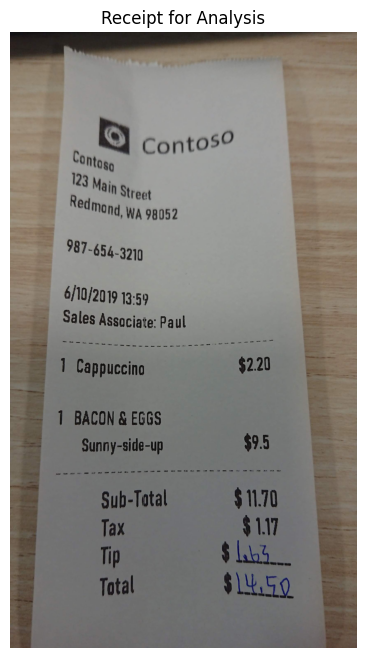

❌ Error analyzing receipt: <urllib3.connection.HTTPSConnection object at 0x0000016200025CD0>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)


In [46]:
def analyze_receipt(document_path_or_url):
    """
    Analyze receipt using prebuilt receipt model
    
    Args:
        document_path_or_url (str): Path to local document or URL
    
    Returns:
        dict: Extracted receipt data
    """
    try:
        print(f"🧾 Analyzing receipt: {document_path_or_url}")
        
        # Display the document
        doc_image = load_and_display_document(document_path_or_url, "Receipt for Analysis")
        if not doc_image:
            return None
        
        # Analyze document using prebuilt receipt model
        if document_path_or_url.startswith('http'):
            poller = document_client.begin_analyze_document_from_url("prebuilt-receipt", document_path_or_url)
        else:
            with open(document_path_or_url, 'rb') as document:
                poller = document_client.begin_analyze_document("prebuilt-receipt", document)
        
        result = poller.result()
        
        # Extract and display receipt information
        receipt_data = {}
        
        print("\n🧾 RECEIPT ANALYSIS RESULTS:")
        print("=" * 60)
        
        for document in result.documents:
            print(f"\n📄 Document type: {document.doc_type}")
            print(f"📊 Confidence: {document.confidence:.2f}")
            
            print("\n🏪 MERCHANT INFO:")
            merchant_fields = ['MerchantName', 'MerchantAddress', 'MerchantPhoneNumber']
            for field_name in merchant_fields:
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   🏢 {field_name}: {field.value}")
                        receipt_data[field_name] = field.value
            
            print("\n📅 TRANSACTION INFO:")
            transaction_fields = ['TransactionDate', 'TransactionTime']
            for field_name in transaction_fields:
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   📋 {field_name}: {field.value}")
                        receipt_data[field_name] = field.value
            
            print("\n💰 FINANCIAL DETAILS:")
            financial_fields = ['Subtotal', 'Tax', 'Total']
            for field_name in financial_fields:
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   💵 {field_name}: {field.value}")
                        receipt_data[field_name] = field.value
            
            # Extract receipt items
            if 'Items' in document.fields:
                items_field = document.fields['Items']
                if items_field.value:
                    print("\n🛒 PURCHASED ITEMS:")
                    items_data = []
                    
                    for i, item in enumerate(items_field.value):
                        item_dict = {}
                        print(f"\n   Item {i+1}:")
                        
                        if item.value:
                            for name, field in item.value.items():
                                if field.value:
                                    print(f"      {name}: {field.value}")
                                    item_dict[name] = field.value
                        
                        items_data.append(item_dict)
                    
                    receipt_data['Items'] = items_data
                    
                    # Create items table
                    if items_data:
                        print("\n📊 ITEMS SUMMARY TABLE:")
                        df_items = pd.DataFrame(items_data)
                        print(tabulate(df_items, headers='keys', tablefmt='grid', showindex=False))
        
        return receipt_data
        
    except Exception as e:
        print(f"❌ Error analyzing receipt: {e}")
        return None

# Test receipt analysis
receipt_path = os.path.join("sample_documents", "receipt.jpg")
if os.path.exists(receipt_path):
    print("\n" + "="*80)
    print("🧾 RECEIPT ANALYSIS DEMO")
    print("="*80)
    receipt_results = analyze_receipt(receipt_path)
else:
    print("❌ Sample receipt not found")


💼 BUSINESS CARD ANALYSIS DEMO
💼 Analyzing business card: sample_documents\business_card.jpg


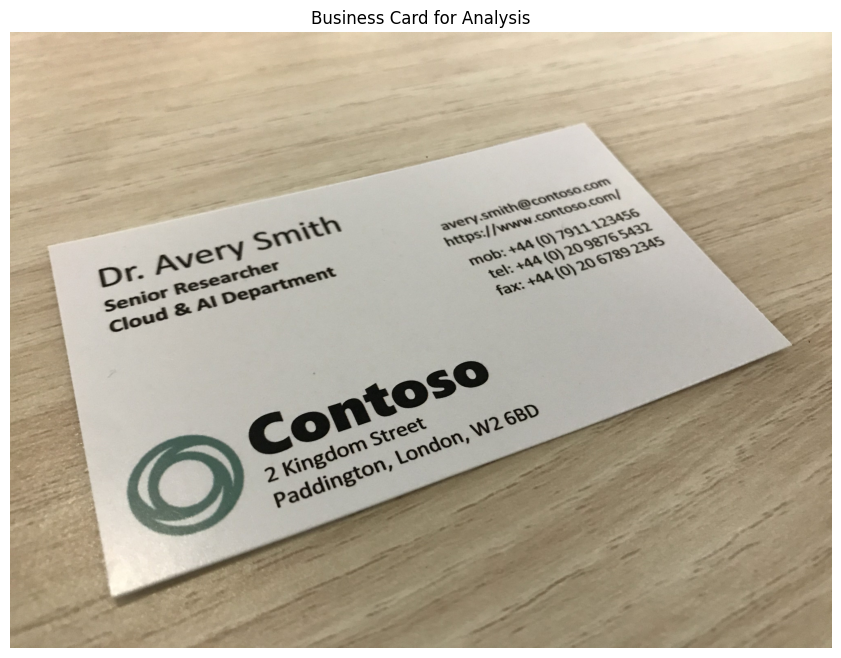

❌ Error analyzing business card: <urllib3.connection.HTTPSConnection object at 0x0000016200079C70>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)


In [47]:
def analyze_business_card(document_path_or_url):
    """
    Analyze business card using prebuilt business card model
    
    Args:
        document_path_or_url (str): Path to local document or URL
    
    Returns:
        dict: Extracted business card data
    """
    try:
        print(f"💼 Analyzing business card: {document_path_or_url}")
        
        # Display the document
        doc_image = load_and_display_document(document_path_or_url, "Business Card for Analysis")
        if not doc_image:
            return None
        
        # Analyze document using prebuilt business card model
        if document_path_or_url.startswith('http'):
            poller = document_client.begin_analyze_document_from_url("prebuilt-businessCard", document_path_or_url)
        else:
            with open(document_path_or_url, 'rb') as document:
                poller = document_client.begin_analyze_document("prebuilt-businessCard", document)
        
        result = poller.result()
        
        # Extract and display business card information
        card_data = {}
        
        print("\n💼 BUSINESS CARD ANALYSIS RESULTS:")
        print("=" * 60)
        
        for document in result.documents:
            print(f"\n📄 Document type: {document.doc_type}")
            print(f"📊 Confidence: {document.confidence:.2f}")
            
            print("\n👤 CONTACT INFORMATION:")
            
            # Extract contact fields
            contact_fields = {
                'ContactNames': '👤 Name',
                'JobTitles': '💼 Job Title',
                'Departments': '🏢 Department',
                'CompanyNames': '🏢 Company',
                'Addresses': '📍 Address',
                'MobilePhones': '📱 Mobile Phone',
                'WorkPhones': '☎️ Work Phone',
                'Faxes': '📠 Fax',
                'Emails': '📧 Email',
                'Websites': '🌐 Website'
            }
            
            for field_name, display_name in contact_fields.items():
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        if isinstance(field.value, list):
                            for item in field.value:
                                if item.value:
                                    print(f"   {display_name}: {item.value}")
                                    if field_name not in card_data:
                                        card_data[field_name] = []
                                    card_data[field_name].append(item.value)
                        else:
                            print(f"   {display_name}: {field.value}")
                            card_data[field_name] = field.value
        
        # Create a summary table
        if card_data:
            print("\n📊 CONTACT SUMMARY:")
            summary_data = []
            for field_name, value in card_data.items():
                if isinstance(value, list):
                    for item in value:
                        summary_data.append([field_name.replace('s', ''), item])
                else:
                    summary_data.append([field_name.replace('s', ''), value])
            
            print(tabulate(summary_data, headers=['Field', 'Value'], tablefmt='grid'))
        
        return card_data
        
    except Exception as e:
        print(f"❌ Error analyzing business card: {e}")
        return None

# Test business card analysis
card_path = os.path.join("sample_documents", "business_card.jpg")
if os.path.exists(card_path):
    print("\n" + "="*80)
    print("💼 BUSINESS CARD ANALYSIS DEMO")
    print("="*80)
    card_results = analyze_business_card(card_path)
else:
    print("❌ Sample business card not found")

## 4. Layout Analysis

Layout analysis extracts text, tables, and structural information from documents without using a specific prebuilt model. This is useful for:
- **General document processing**: Any document type
- **Table extraction**: Structured data from tables
- **Reading order**: Logical reading sequence
- **Document structure**: Headers, paragraphs, lists

In [48]:
def analyze_document_layout(document_path_or_url):
    """
    Analyze document layout and structure
    
    Args:
        document_path_or_url (str): Path to local document or URL
    
    Returns:
        dict: Layout analysis results
    """
    try:
        print(f"📋 Analyzing document layout: {document_path_or_url}")
        
        # Display the document
        if not document_path_or_url.endswith('.pdf'):
            doc_image = load_and_display_document(document_path_or_url, "Document for Layout Analysis")
        else:
            print("📄 PDF document loaded for layout analysis")
        
        # Analyze document using layout model
        if document_path_or_url.startswith('http'):
            poller = document_client.begin_analyze_document_from_url("prebuilt-layout", document_path_or_url)
        else:
            with open(document_path_or_url, 'rb') as document:
                poller = document_client.begin_analyze_document("prebuilt-layout", document)
        
        result = poller.result()
        
        # Extract layout information
        layout_data = {
            'pages': [],
            'tables': [],
            'paragraphs': [],
            'lines': []
        }
        
        print("\n📋 LAYOUT ANALYSIS RESULTS:")
        print("=" * 60)
        
        # Pages information
        print(f"\n📄 DOCUMENT PAGES: {len(result.pages)}")
        for page_idx, page in enumerate(result.pages):
            page_info = {
                'page_number': page_idx + 1,
                'width': page.width,
                'height': page.height,
                'angle': page.angle,
                'lines_count': len(page.lines)
            }
            layout_data['pages'].append(page_info)
            print(f"   📄 Page {page_idx + 1}: {page.width}x{page.height}, {len(page.lines)} lines")
        
        # Tables information
        if result.tables:
            print(f"\n📊 TABLES FOUND: {len(result.tables)}")
            for table_idx, table in enumerate(result.tables):
                table_info = {
                    'table_number': table_idx + 1,
                    'row_count': table.row_count,
                    'column_count': table.column_count,
                    'cells': []
                }
                
                print(f"\n   📊 Table {table_idx + 1}: {table.row_count} rows × {table.column_count} columns")
                
                # Extract table data
                table_matrix = [["" for _ in range(table.column_count)] for _ in range(table.row_count)]
                
                for cell in table.cells:
                    if cell.row_index < table.row_count and cell.column_index < table.column_count:
                        table_matrix[cell.row_index][cell.column_index] = cell.content
                        table_info['cells'].append({
                            'row': cell.row_index,
                            'column': cell.column_index,
                            'content': cell.content,
                            'kind': cell.kind if hasattr(cell, 'kind') else 'content'
                        })
                
                # Display table
                print(f"\n      Table {table_idx + 1} Content:")
                print(tabulate(table_matrix, tablefmt='grid'))
                
                layout_data['tables'].append(table_info)
        
        # Paragraphs information
        if hasattr(result, 'paragraphs') and result.paragraphs:
            print(f"\n📝 PARAGRAPHS FOUND: {len(result.paragraphs)}")
            for para_idx, paragraph in enumerate(result.paragraphs[:5]):  # Show first 5 paragraphs
                para_info = {
                    'paragraph_number': para_idx + 1,
                    'content': paragraph.content,
                    'role': paragraph.role if hasattr(paragraph, 'role') else 'paragraph'
                }
                layout_data['paragraphs'].append(para_info)
                print(f"   📝 Paragraph {para_idx + 1}: {paragraph.content[:100]}...")
                if hasattr(paragraph, 'role') and paragraph.role:
                    print(f"      Role: {paragraph.role}")
        
        # Text content
        print(f"\n📄 EXTRACTED TEXT (first 500 characters):")
        if result.content:
            print(f"'{result.content[:500]}...")
            layout_data['full_text'] = result.content
        
        return layout_data
        
    except Exception as e:
        print(f"❌ Error analyzing layout: {e}")
        return None

# Test layout analysis
layout_doc_path = os.path.join("sample_documents", "layout_document.jpg")
if os.path.exists(layout_doc_path):
    print("\n" + "="*80)
    print("📋 DOCUMENT LAYOUT ANALYSIS DEMO")
    print("="*80)
    layout_results = analyze_document_layout(layout_doc_path)
else:
    # Try with invoice if layout document not available
    invoice_path = os.path.join("sample_documents", "invoice.pdf")
    if os.path.exists(invoice_path):
        print("\n" + "="*80)
        print("📋 DOCUMENT LAYOUT ANALYSIS DEMO (using invoice)")
        print("="*80)
        layout_results = analyze_document_layout(invoice_path)
    else:
        print("❌ No sample documents found for layout analysis")


📋 DOCUMENT LAYOUT ANALYSIS DEMO (using invoice)
📋 Analyzing document layout: sample_documents\invoice.pdf
📄 PDF document loaded for layout analysis
❌ Error analyzing layout: <urllib3.connection.HTTPSConnection object at 0x0000016278928AD0>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)



🆔 ID DOCUMENT ANALYSIS DEMO
🆔 Analyzing ID document: sample_documents\id_document.jpg


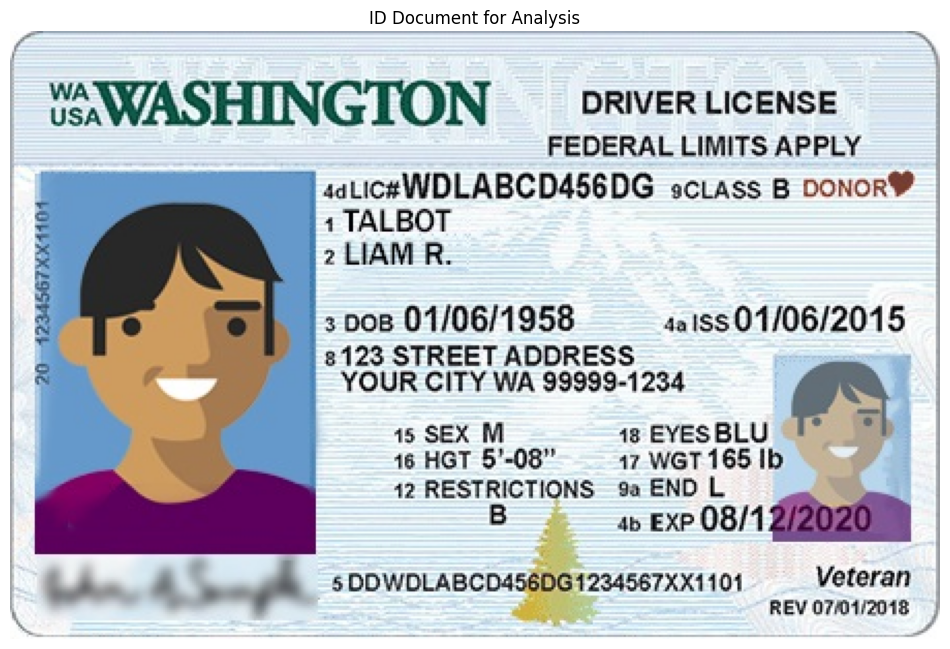

❌ Error analyzing ID document: <urllib3.connection.HTTPSConnection object at 0x00000162000257F0>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)


In [49]:
def analyze_id_document(document_path_or_url):
    """
    Analyze ID document using prebuilt ID document model
    
    Args:
        document_path_or_url (str): Path to local document or URL
    
    Returns:
        dict: Extracted ID document data
    """
    try:
        print(f"🆔 Analyzing ID document: {document_path_or_url}")
        
        # Display the document
        doc_image = load_and_display_document(document_path_or_url, "ID Document for Analysis")
        if not doc_image:
            return None
        
        # Analyze document using prebuilt ID document model
        if document_path_or_url.startswith('http'):
            poller = document_client.begin_analyze_document_from_url("prebuilt-idDocument", document_path_or_url)
        else:
            with open(document_path_or_url, 'rb') as document:
                poller = document_client.begin_analyze_document("prebuilt-idDocument", document)
        
        result = poller.result()
        
        # Extract and display ID document information
        id_data = {}
        
        print("\n🆔 ID DOCUMENT ANALYSIS RESULTS:")
        print("=" * 60)
        
        for document in result.documents:
            print(f"\n📄 Document type: {document.doc_type}")
            print(f"📊 Confidence: {document.confidence:.2f}")
            
            print("\n👤 PERSONAL INFORMATION:")
            
            # Extract ID fields
            id_fields = {
                'FirstName': '👤 First Name',
                'LastName': '👤 Last Name',
                'DocumentNumber': '🆔 Document Number',
                'DateOfBirth': '📅 Date of Birth',
                'DateOfExpiration': '📅 Expiration Date',
                'Sex': '⚧ Sex',
                'Address': '📍 Address',
                'CountryRegion': '🌍 Country/Region',
                'Region': '📍 State/Region'
            }
            
            for field_name, display_name in id_fields.items():
                if field_name in document.fields:
                    field = document.fields[field_name]
                    if field.value:
                        print(f"   {display_name}: {field.value}")
                        id_data[field_name] = field.value
        
        # Create a summary table
        if id_data:
            print("\n📊 ID DOCUMENT SUMMARY:")
            summary_data = [[field_name, value] for field_name, value in id_data.items()]
            print(tabulate(summary_data, headers=['Field', 'Value'], tablefmt='grid'))
        
        return id_data
        
    except Exception as e:
        print(f"❌ Error analyzing ID document: {e}")
        return None

# Test ID document analysis
id_doc_path = os.path.join("sample_documents", "id_document.jpg")
if os.path.exists(id_doc_path):
    print("\n" + "="*80)
    print("🆔 ID DOCUMENT ANALYSIS DEMO")
    print("="*80)
    id_results = analyze_id_document(id_doc_path)
else:
    print("❌ Sample ID document not found")

## 5. General Document Analysis

General document analysis can process any document type and extract:
- **Text content**: All readable text
- **Key-value pairs**: Form fields and their values
- **Tables**: Structured tabular data
- **Selection marks**: Checkboxes and radio buttons

In [50]:
def analyze_general_document(document_path_or_url):
    """
    Perform general document analysis
    
    Args:
        document_path_or_url (str): Path to local document or URL
    
    Returns:
        dict: General analysis results
    """
    try:
        print(f"📄 Performing general document analysis: {document_path_or_url}")
        
        # Display the document
        if not document_path_or_url.endswith('.pdf'):
            doc_image = load_and_display_document(document_path_or_url, "Document for General Analysis")
        else:
            print("📄 PDF document loaded for general analysis")
        
        # Analyze document using general document model
        if document_path_or_url.startswith('http'):
            poller = document_client.begin_analyze_document_from_url("prebuilt-document", document_path_or_url)
        else:
            with open(document_path_or_url, 'rb') as document:
                poller = document_client.begin_analyze_document("prebuilt-document", document)
        
        result = poller.result()
        
        # Extract general document information
        doc_data = {
            'key_value_pairs': [],
            'tables': [],
            'text_content': '',
            'selection_marks': []
        }
        
        print("\n📄 GENERAL DOCUMENT ANALYSIS RESULTS:")
        print("=" * 60)
        
        # Key-value pairs
        if result.key_value_pairs:
            print(f"\n🔑 KEY-VALUE PAIRS FOUND: {len(result.key_value_pairs)}")
            for kv_idx, kv_pair in enumerate(result.key_value_pairs[:10]):  # Show first 10
                key_text = kv_pair.key.content if kv_pair.key else "No key"
                value_text = kv_pair.value.content if kv_pair.value else "No value"
                
                kv_data = {
                    'key': key_text,
                    'value': value_text
                }
                doc_data['key_value_pairs'].append(kv_data)
                
                print(f"   🔑 {key_text}: {value_text}")
        
        # Tables (reuse from layout analysis)
        if result.tables:
            print(f"\n📊 TABLES FOUND: {len(result.tables)}")
            for table_idx, table in enumerate(result.tables[:3]):  # Show first 3 tables
                print(f"\n   📊 Table {table_idx + 1}: {table.row_count} rows × {table.column_count} columns")
                
                # Extract table data
                table_matrix = [["" for _ in range(table.column_count)] for _ in range(table.row_count)]
                
                for cell in table.cells:
                    if cell.row_index < table.row_count and cell.column_index < table.column_count:
                        table_matrix[cell.row_index][cell.column_index] = cell.content
                
                # Display table
                print(f"\n      Table {table_idx + 1} Content:")
                print(tabulate(table_matrix, tablefmt='grid'))
                
                doc_data['tables'].append({
                    'table_number': table_idx + 1,
                    'row_count': table.row_count,
                    'column_count': table.column_count,
                    'data': table_matrix
                })
        
        # Text content
        if result.content:
            doc_data['text_content'] = result.content
            print(f"\n📄 EXTRACTED TEXT (first 300 characters):")
            print(f"'{result.content[:300]}...'")
        
        # Selection marks (checkboxes, radio buttons)
        if hasattr(result, 'pages'):
            selection_marks_count = 0
            for page in result.pages:
                if hasattr(page, 'selection_marks'):
                    for mark in page.selection_marks:
                        selection_marks_count += 1
                        doc_data['selection_marks'].append({
                            'state': mark.state,
                            'confidence': mark.confidence
                        })
            
            if selection_marks_count > 0:
                print(f"\n☑️ SELECTION MARKS FOUND: {selection_marks_count}")
                selected_count = len([m for m in doc_data['selection_marks'] if m['state'] == 'selected'])
                unselected_count = len([m for m in doc_data['selection_marks'] if m['state'] == 'unselected'])
                print(f"   ✅ Selected: {selected_count}")
                print(f"   ⬜ Unselected: {unselected_count}")
        
        return doc_data
        
    except Exception as e:
        print(f"❌ Error in general document analysis: {e}")
        return None

# Test general document analysis with available documents
test_documents = ["invoice.pdf", "receipt.jpg", "business_card.jpg"]

for doc_name in test_documents:
    doc_path = os.path.join("sample_documents", doc_name)
    if os.path.exists(doc_path):
        print("\n" + "="*80)
        print(f"📄 GENERAL DOCUMENT ANALYSIS: {doc_name}")
        print("="*80)
        general_results = analyze_general_document(doc_path)
        break
else:
    print("❌ No sample documents found for general analysis")


📄 GENERAL DOCUMENT ANALYSIS: invoice.pdf
📄 Performing general document analysis: sample_documents\invoice.pdf
📄 PDF document loaded for general analysis
❌ Error in general document analysis: <urllib3.connection.HTTPSConnection object at 0x0000016278937740>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)


## 6. Batch Document Processing

Process multiple documents efficiently with batch operations.

In [51]:
def batch_analyze_documents(document_paths, model_type="prebuilt-document"):
    """
    Analyze multiple documents in batch
    
    Args:
        document_paths (list): List of document paths
        model_type (str): Type of model to use
    
    Returns:
        list: Analysis results for all documents
    """
    print(f"📊 Batch processing {len(document_paths)} documents with {model_type} model...")
    
    results = []
    model_functions = {
        "prebuilt-invoice": "Invoice",
        "prebuilt-receipt": "Receipt", 
        "prebuilt-businessCard": "Business Card",
        "prebuilt-idDocument": "ID Document",
        "prebuilt-layout": "Layout",
        "prebuilt-document": "General Document"
    }
    
    for i, doc_path in enumerate(document_paths, 1):
        try:
            print(f"\n🔄 Processing document {i}/{len(document_paths)}: {os.path.basename(doc_path)}")
            
            # Analyze document
            with open(doc_path, 'rb') as document:
                poller = document_client.begin_analyze_document(model_type, document)
            
            result = poller.result()
            
            # Extract basic information
            doc_result = {
                'document': os.path.basename(doc_path),
                'model_type': model_type,
                'success': True,
                'pages_count': len(result.pages) if result.pages else 0,
                'tables_count': len(result.tables) if result.tables else 0,
                'content_length': len(result.content) if result.content else 0
            }
            
            # Extract model-specific information
            if result.documents:
                doc_result['documents_found'] = len(result.documents)
                doc_result['document_types'] = [doc.doc_type for doc in result.documents]
                doc_result['confidence_scores'] = [doc.confidence for doc in result.documents]
            
            print(f"   ✅ Success: {doc_result['pages_count']} pages, {doc_result['tables_count']} tables")
            
            results.append(doc_result)
            
        except Exception as e:
            print(f"   ❌ Error processing {doc_path}: {e}")
            results.append({
                'document': os.path.basename(doc_path),
                'model_type': model_type,
                'success': False,
                'error': str(e)
            })
    
    # Summary
    print(f"\n📈 BATCH PROCESSING SUMMARY:")
    successful = len([r for r in results if r['success']])
    failed = len([r for r in results if not r['success']])
    print(f"   ✅ Successful: {successful}")
    print(f"   ❌ Failed: {failed}")
    
    # Create summary table
    if results:
        print(f"\n📊 RESULTS SUMMARY:")
        summary_data = []
        for result in results:
            if result['success']:
                summary_data.append([
                    result['document'],
                    result['model_type'],
                    result['pages_count'],
                    result['tables_count'],
                    result['content_length']
                ])
            else:
                summary_data.append([
                    result['document'],
                    result['model_type'],
                    "Error",
                    "Error", 
                    "Error"
                ])
        
        headers = ['Document', 'Model', 'Pages', 'Tables', 'Content Length']
        print(tabulate(summary_data, headers=headers, tablefmt='grid'))
    
    return results

# Test batch processing with available documents
available_docs = []
for doc_name in sample_documents.keys():
    doc_path = os.path.join("sample_documents", doc_name)
    if os.path.exists(doc_path):
        available_docs.append(doc_path)

if available_docs:
    print("\n" + "="*80)
    print("📊 BATCH DOCUMENT PROCESSING DEMO")
    print("="*80)
    
    # Test batch processing with general document model
    batch_results = batch_analyze_documents(available_docs, "prebuilt-document")
else:
    print("❌ No sample documents available for batch processing")


📊 BATCH DOCUMENT PROCESSING DEMO
📊 Batch processing 4 documents with prebuilt-document model...

🔄 Processing document 1/4: invoice.pdf
   ❌ Error processing sample_documents\invoice.pdf: <urllib3.connection.HTTPSConnection object at 0x000001627892B770>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)

🔄 Processing document 2/4: receipt.jpg
   ❌ Error processing sample_documents\receipt.jpg: <urllib3.connection.HTTPSConnection object at 0x00000162789297C0>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)

🔄 Processing document 3/4: business_card.jpg
   ❌ Error processing sample_documents\business_card.jpg: <urllib3.connection.HTTPSConnection object at 0x00000162789CA840>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)

🔄 Processing document 4/4: id_document.jpg
   ❌ Error pr

## 7. Performance Monitoring and Optimization

### ⚡ Performance Tips
- **Document optimization**: Ensure good quality scans
- **File size management**: Optimize large documents
- **Batch operations**: Process multiple documents together
- **Model selection**: Choose the right prebuilt model
- **Error handling**: Implement retry logic for failures

In [52]:
import time
from datetime import datetime

def performance_test_document_intelligence(document_paths, model_type="prebuilt-document"):
    """
    Test Document Intelligence API performance
    
    Args:
        document_paths (list): List of document paths to test
        model_type (str): Type of model to test
    
    Returns:
        dict: Performance metrics
    """
    print(f"⚡ Performance Testing - {model_type} Analysis")
    print(f"📊 Testing with {len(document_paths)} documents")
    
    results = {
        'total_time': 0,
        'successful_operations': 0,
        'failed_operations': 0,
        'average_time_per_document': 0,
        'documents_per_minute': 0,
        'start_time': datetime.now(),
        'model_type': model_type
    }
    
    start_time = time.time()
    
    for i, doc_path in enumerate(document_paths, 1):
        print(f"\n🔄 Processing document {i}/{len(document_paths)}...")
        doc_start = time.time()
        
        try:
            with open(doc_path, 'rb') as document:
                poller = document_client.begin_analyze_document(model_type, document)
            
            result = poller.result()
            
            doc_end = time.time()
            doc_time = doc_end - doc_start
            
            # Check if analysis was successful
            success = result and (result.content or result.tables or result.pages)
            
            if success:
                results['successful_operations'] += 1
                print(f"   ✅ Completed in {doc_time:.2f} seconds")
                if result.pages:
                    print(f"      📄 Pages: {len(result.pages)}")
                if result.tables:
                    print(f"      📊 Tables: {len(result.tables)}")
                if result.content:
                    print(f"      📝 Text length: {len(result.content)} characters")
            else:
                results['failed_operations'] += 1
                print(f"   ❌ Failed after {doc_time:.2f} seconds")
                
        except Exception as e:
            results['failed_operations'] += 1
            doc_time = time.time() - doc_start
            print(f"   ❌ Error after {doc_time:.2f} seconds: {e}")
    
    end_time = time.time()
    results['total_time'] = end_time - start_time
    results['end_time'] = datetime.now()
    
    if results['successful_operations'] > 0:
        results['average_time_per_document'] = results['total_time'] / results['successful_operations']
        results['documents_per_minute'] = 60 / results['average_time_per_document']
    
    # Display results
    print(f"\n📊 Performance Test Results:")
    print(f"   ⏱️ Total Time: {results['total_time']:.2f} seconds")
    print(f"   ✅ Successful: {results['successful_operations']}")
    print(f"   ❌ Failed: {results['failed_operations']}")
    print(f"   📈 Average Time/Document: {results['average_time_per_document']:.2f} seconds")
    print(f"   🚀 Documents/Minute: {results['documents_per_minute']:.1f}")
    print(f"   📅 Test Duration: {results['start_time'].strftime('%H:%M:%S')} - {results['end_time'].strftime('%H:%M:%S')}")
    
    return results

# Run performance tests if documents are available
if available_docs and len(available_docs) >= 2:
    print("\n" + "="*80)
    print("⚡ DOCUMENT INTELLIGENCE PERFORMANCE TESTING")
    print("="*80)
    
    # Test with different models
    models_to_test = ["prebuilt-document", "prebuilt-layout"]
    
    for model in models_to_test:
        print(f"\n🧪 Testing {model} model:")
        perf_results = performance_test_document_intelligence(available_docs[:3], model)
else:
    print("\n💡 Not enough sample documents for performance testing")


⚡ DOCUMENT INTELLIGENCE PERFORMANCE TESTING

🧪 Testing prebuilt-document model:
⚡ Performance Testing - prebuilt-document Analysis
📊 Testing with 3 documents

🔄 Processing document 1/3...
   ❌ Error after 0.00 seconds: <urllib3.connection.HTTPSConnection object at 0x000001627776F980>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)

🔄 Processing document 2/3...
   ❌ Error after 0.00 seconds: <urllib3.connection.HTTPSConnection object at 0x000001620005F4D0>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)

🔄 Processing document 3/3...
   ❌ Error after 0.00 seconds: <urllib3.connection.HTTPSConnection object at 0x00000162000257F0>: Failed to resolve 'your-document-intelligence-resource.cognitiveservices.azure.com' ([Errno 11001] getaddrinfo failed)

📊 Performance Test Results:
   ⏱️ Total Time: 0.01 seconds
   ✅ Successful: 0
   ❌ Failed: 3
   📈 A

## 8. Interactive Demo

Try Document Intelligence features with your own documents!

In [53]:
# 🎯 Interactive Document Intelligence Demo
# Customize these variables and run the cell!

# Option 1: Use a URL to a document
your_document_url = "https://example.com/your-document.pdf"  # Replace with your document URL

# Option 2: Use a local document path
your_local_document = "path/to/your/document.pdf"  # Replace with your local document path

# Choose analysis type
analysis_models = {
    'invoice': 'prebuilt-invoice - Extract invoice data',
    'receipt': 'prebuilt-receipt - Extract receipt data', 
    'business_card': 'prebuilt-businessCard - Extract contact info',
    'id_document': 'prebuilt-idDocument - Extract ID information',
    'layout': 'prebuilt-layout - Extract structure and tables',
    'general': 'prebuilt-document - General document analysis'
}

selected_model = 'general'  # Change this to test different models

def interactive_document_analysis(document_source, model_type='general'):
    """
    Interactive analysis function for testing
    """
    model_mapping = {
        'invoice': 'prebuilt-invoice',
        'receipt': 'prebuilt-receipt',
        'business_card': 'prebuilt-businessCard',
        'id_document': 'prebuilt-idDocument', 
        'layout': 'prebuilt-layout',
        'general': 'prebuilt-document'
    }
    
    actual_model = model_mapping.get(model_type, 'prebuilt-document')
    print(f"🎯 Running {actual_model} analysis on your document...")
    
    try:
        if document_source.startswith('http'):
            poller = document_client.begin_analyze_document_from_url(actual_model, document_source)
        else:
            with open(document_source, 'rb') as document:
                poller = document_client.begin_analyze_document(actual_model, document)
        
        result = poller.result()
        
        # Basic results
        print(f"\n📊 Analysis completed successfully!")
        print(f"   📄 Pages: {len(result.pages) if result.pages else 0}")
        print(f"   📊 Tables: {len(result.tables) if result.tables else 0}")
        print(f"   📝 Text length: {len(result.content) if result.content else 0} characters")
        
        if result.documents:
            print(f"   📋 Documents found: {len(result.documents)}")
            for doc in result.documents:
                print(f"      Type: {doc.doc_type}, Confidence: {doc.confidence:.2f}")
        
        # Show first 200 characters of text
        if result.content:
            print(f"\n📄 Text preview: '{result.content[:200]}...'")
        
        return result
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Instructions for use
print("🎯 INTERACTIVE DOCUMENT INTELLIGENCE DEMO")
print("=" * 50)
print("To use this demo:")
print("1. Replace 'your_document_url' or 'your_local_document' with your document")
print("2. Choose your analysis model from:")
for key, description in analysis_models.items():
    print(f"   • {key}: {description}")
print("3. Set 'selected_model' variable")
print("4. Uncomment the analysis code below")
print("\n💡 Available models:", list(analysis_models.keys()))

# Test with sample documents if available
if available_docs:
    print(f"\n🔧 Testing with sample document: {os.path.basename(available_docs[0])}")
    # Uncomment to test with first available sample document
    # sample_result = interactive_document_analysis(available_docs[0], selected_model)

# Uncomment the lines below to test with your document
# if your_document_url != "https://example.com/your-document.pdf":
#     result = interactive_document_analysis(your_document_url, selected_model)
# elif os.path.exists(your_local_document):
#     result = interactive_document_analysis(your_local_document, selected_model)
# else:
#     print("❌ Please provide a valid document URL or local path")

print("\n🚀 Ready to analyze your documents!")

🎯 INTERACTIVE DOCUMENT INTELLIGENCE DEMO
To use this demo:
1. Replace 'your_document_url' or 'your_local_document' with your document
2. Choose your analysis model from:
   • invoice: prebuilt-invoice - Extract invoice data
   • receipt: prebuilt-receipt - Extract receipt data
   • business_card: prebuilt-businessCard - Extract contact info
   • id_document: prebuilt-idDocument - Extract ID information
   • layout: prebuilt-layout - Extract structure and tables
   • general: prebuilt-document - General document analysis
3. Set 'selected_model' variable
4. Uncomment the analysis code below

💡 Available models: ['invoice', 'receipt', 'business_card', 'id_document', 'layout', 'general']

🔧 Testing with sample document: invoice.pdf

🚀 Ready to analyze your documents!


## 9. Troubleshooting and Best Practices

### 🔧 Common Issues and Solutions

1. **Authentication Errors**
   - ❌ "Access denied" or "Invalid subscription key"
   - ✅ Check your Document Intelligence key and endpoint
   - ✅ Verify the resource is in the correct region

2. **Document Format Issues**
   - ❌ "Unsupported file format"
   - ✅ Supported formats: PDF, JPEG, PNG, BMP, TIFF
   - ✅ Maximum file size: 500 MB for paid tier, 4 MB for free tier
   - ✅ PDF: Maximum 2000 pages

3. **Quality Issues**
   - ❌ Poor extraction accuracy
   - ✅ Ensure good scan quality and resolution
   - ✅ Avoid skewed or rotated documents
   - ✅ Use appropriate lighting and contrast

4. **Model Selection**
   - ❌ Wrong model for document type
   - ✅ Use prebuilt models when available
   - ✅ Fall back to layout/general models for unknown types
   - ✅ Consider custom models for specialized documents

### 💡 Best Practices

- **Document Quality**: Use high-resolution, well-lit scans
- **Model Selection**: Choose the most specific prebuilt model
- **Error Handling**: Always implement try-catch blocks
- **Caching**: Cache results for frequently processed documents
- **Monitoring**: Track API usage and costs
- **Security**: Use managed identity in production
- **Preprocessing**: Optimize document quality before processing

## 10. Conclusion and Next Steps

🎉 **Congratulations!** You've successfully explored Azure AI Document Intelligence capabilities including:
- ✅ Prebuilt models (Invoice, Receipt, Business Card, ID Document)
- ✅ Layout analysis and table extraction
- ✅ General document processing
- ✅ Key-value pair extraction
- ✅ Batch processing
- ✅ Performance optimization

### 🚀 Next Steps
1. **Complete Azure AI Series** - You've finished all notebooks:
   - ✅ Azure AI Language Services
   - ✅ Azure AI Speech Services
   - ✅ Azure AI Vision Services
   - ✅ Azure AI Document Intelligence

2. **Build real applications** using Document Intelligence:
   - Invoice processing automation
   - Receipt digitization systems
   - Business card management
   - Document workflow automation
   - Compliance and audit systems

3. **Advanced features to explore**:
   - Custom model training
   - Document classification
   - Composed models
   - REST API integration
   - Azure Logic Apps integration

### 📚 Additional Resources
- [Azure Document Intelligence Documentation](https://docs.microsoft.com/azure/applied-ai-services/form-recognizer/)
- [Document Intelligence SDK Samples](https://github.com/Azure/azure-sdk-for-python/tree/main/sdk/formrecognizer)
- [Document Intelligence Studio](https://formrecognizer.appliedai.azure.com/) - Test and train models
- [Pricing Information](https://azure.microsoft.com/pricing/details/form-recognizer/)

### 🔗 Useful Links
- [Supported File Formats](https://docs.microsoft.com/azure/applied-ai-services/form-recognizer/concept-model-overview)
- [Prebuilt Models Overview](https://docs.microsoft.com/azure/applied-ai-services/form-recognizer/concept-model-overview#prebuilt-models)
- [Custom Model Training](https://docs.microsoft.com/azure/applied-ai-services/form-recognizer/concept-custom)
- [API Reference](https://docs.microsoft.com/rest/api/formrecognizer/)
- [SDK Reference](https://docs.microsoft.com/python/api/azure-ai-formrecognizer/)

**Happy document processing with Azure AI Document Intelligence! 📄🤖**

---

## 🎯 Azure AI Services Demo Series Complete!

You have now completed the full Azure AI Services demo series. These notebooks provide a comprehensive foundation for building intelligent applications using:

- 🗣️ **Language Services**: Text analytics and natural language processing
- 🎤 **Speech Services**: Speech-to-text, text-to-speech, and translation
- 👁️ **Vision Services**: Image analysis, OCR, and object detection
- 📄 **Document Intelligence**: Structured data extraction from documents

Start building amazing AI-powered applications! 🚀